In [1]:
import tensorflow as tf
import pandas as pd

from tensorflow.keras.callbacks  import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import os
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
import io
from IPython.display import clear_output,display


In [2]:
image_path="../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/train/"

In [3]:
cls_name=os.listdir(image_path)
print(cls_name)

['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']


In [4]:
print("Number of classes : {}".format(len(cls_name)))

Number of classes : 5


In [5]:
number_of_images={}
for class_name in cls_name:
    number_of_images[class_name]=len(os.listdir(image_path+"/"+class_name))
images_each_class=pd.DataFrame(number_of_images.values(),index=number_of_images.keys(),columns=["Number of images"])
images_each_class

,Number of images
Final AD JPEG,145
Final LMCI JPEG,61
Final MCI JPEG,198
Final CN JPEG,493
Final EMCI JPEG,204


In [6]:
label_name=["Final AD JPEG","Final CN JPEG","Final EMCI JPEG","Final LMCI JPEG","Final MCI JPEG"]

train data and test data preprocessing

In [7]:
print("presprocess train data\n")

image_data=[]
label_data=[]
image_size=150

for i in label_name:
    data_path=os.path.join("../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/","train",i)
    for m in tqdm(os.listdir(data_path)):
        image=cv2.imread(os.path.join(data_path,m))
        image=cv2.resize(image,(image_size,image_size))
        
        image_data.append(image)
        label_data.append(i)

    



for i in label_name:
    data_path=os.path.join("../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/","test",i)
    for m in tqdm(os.listdir(data_path)):
        image=cv2.imread(os.path.join(data_path,m))
        image=cv2.resize(image,(image_size,image_size))
        
        image_data.append(image)
        label_data.append(i)
        
image_data=np.array(image_data)
label_data=np.array(label_data)

presprocess train data



100%|██████████| 35/35 [00:00<00:00, 689.94it/s]


In [8]:
image_data.shape

(1296, 150, 150, 3)

In [9]:
image_data,label_data=shuffle(image_data,label_data,random_state=42)

In [10]:
X_train,X_test,Y_train,Y_test=train_test_split(image_data,label_data,test_size=0.2,random_state=42)

apply onehot encoding

In [11]:
train_label_data_new=[]
test_label_data_new=[]
for n in Y_train:
    train_label_data_new.append(label_name.index(n))
Y_train=train_label_data_new
Y_train=to_categorical(Y_train)
    
for n in Y_test:
    test_label_data_new.append(label_name.index(n))
Y_test=test_label_data_new
Y_test=to_categorical(Y_test)
    
    
    


In [12]:
Y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [13]:
efficientNetB6=tf.keras.applications.efficientnet.EfficientNetB6(weights="imagenet",include_top=False,input_shape=(150,150,3))
model=efficientNetB6.output
model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense(5,activation="softmax")(model)  
model=tf.keras.models.Model(inputs=efficientNetB6.input,outputs=model)                                                                  
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()
                                                               

2022-10-12 18:22:54.061947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 18:22:54.070205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 18:22:54.070938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 18:22:54.073484: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
tensorboard = TensorBoard(log_dir="logs")
checkpoint = ModelCheckpoint("efficient_B6.h5", 
                            monitor='val_accuracy', 
                            mode = "auto", 
                            verbose = 1,
                            save_best_only =True)

2022-10-12 18:22:59.490398: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-12 18:22:59.490502: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-12 18:22:59.490561: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-12 18:22:59.632395: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-12 18:22:59.632571: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [15]:
reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

In [16]:
history = model.fit(X_train, Y_train,
                  validation_data =(X_test,Y_test),
                  epochs =80, 
                  verbose =1, 
                  batch_size = 10, 
                  callbacks = [tensorboard, checkpoint, reduce_LR])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-10-12 18:23:00.147970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-10-12 18:23:22.404078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/104 [..............................] - ETA: 41:00 - loss: 1.5691 - accuracy: 0.3000

2022-10-12 18:23:24.743781: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-12 18:23:24.743836: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/104 [..............................] - ETA: 2:08 - loss: 1.6333 - accuracy: 0.2000 

2022-10-12 18:23:25.324427: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-12 18:23:25.329002: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-12 18:23:25.534651: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5714 callback api events and 5711 activity events. 
2022-10-12 18:23:25.676097: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-12 18:23:25.841578: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_12_18_23_25

2022-10-12 18:23:25.943031: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_12_18_23_25/ad3837ecb871.trace.json.gz
2022-10-12 18:23:26.158705: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

104/104 [==============================] - 52s 273ms/step - loss: 1.5086 - accuracy: 0.3851 - val_loss: 1.3545 - val_accuracy: 0.4962

Epoch 00001: val_accuracy improved from -inf to 0.49615, saving model to efficient_B6.h5
Epoch 2/80
104/104 [==============================] - 22s 209ms/step - loss: 1.3594 - accuracy: 0.4498 - val_loss: 1.6600 - val_accuracy: 0.4962

Epoch 00002: val_accuracy did not improve from 0.49615
Epoch 3/80
104/104 [==============================] - 22s 214ms/step - loss: 1.2807 - accuracy: 0.4701 - val_loss: 2.3896 - val_accuracy: 0.4615

Epoch 00003: val_accuracy did not improve from 0.49615

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/80
104/104 [==============================] - 22s 213ms/step - loss: 1.0846 - accuracy: 0.5685 - val_loss: 1.9989 - val_accuracy: 0.2154

Epoch 00004: val_accuracy did not improve from 0.49615
Epoch 5/80
104/104 [==============================] - 22s 210ms/step - loss: 0.7783 - accura

In [17]:
result= model.evaluate(X_test,Y_test,batch_size=10)
print("Accuracy is\n",result)

                      

26/26 [==============================] - 1s 39ms/step - loss: 2.2453 - accuracy: 0.4808
Accuracy is
 [2.2453112602233887, 0.48076921701431274]


history for accuracy

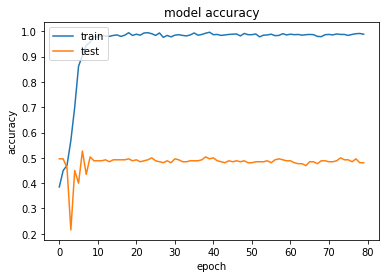

In [18]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 history for loss

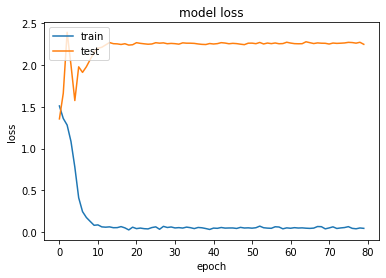

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# %load_ext tensorboard

In [21]:
#  %reload_ext tensorboard

In [22]:
# %tensorboard --logdir logs/fit

In [23]:
prediction=model.predict(X_test)

pred_label=np.argmax(prediction,axis=1)

y_pred=np.argmax(Y_test,axis=1)



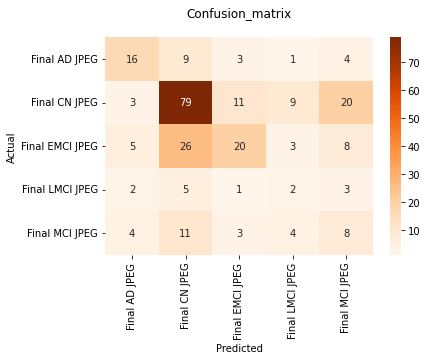

In [24]:
cm = confusion_matrix(y_pred,pred_label)
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="Oranges",xticklabels=label_name,yticklabels=label_name)
plt.title("Confusion_matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
print(classification_report(y_pred, pred_label,target_names=["Final AD JPEG" , "Final CN JPEG",  "Final EMCI JPEG","Final LMCI JPEG","Final MCI JPEG"]))

                 precision    recall  f1-score   support

  Final AD JPEG       0.53      0.48      0.51        33
  Final CN JPEG       0.61      0.65      0.63       122
Final EMCI JPEG       0.53      0.32      0.40        62
Final LMCI JPEG       0.11      0.15      0.12        13
 Final MCI JPEG       0.19      0.27      0.22        30

       accuracy                           0.48       260
      macro avg       0.39      0.38      0.38       260
   weighted avg       0.51      0.48      0.49       260



Data Prediction

In [26]:
def image_prediction(upload):
    for name, fileinfo in uploader.value.items():
        image_file=Image.open(io.BytesIO(fileinfo["content"]))
    predict_image=cv2.cvtColor(np.array(image_file),cv2.COLOR_RGB2BGR)
    predict_image=cv2.resize(predict_image,(150,150))
    predict_image=predict_image.reshape(1,150,150,3)
    predict_image=model.predict(predict_image)
    predict_image=np.argmax(predict_image,axis=1)[0]
    
    if predict_image==0:
        predict_image="Final AD JPEG"
    elif predict_image==1:
        predict_image="Final CN JPEG"
    elif predict_image==2:
        predict_image="Final EMCI JPEG"
    elif predict_image==3:
        predict_image="Final LMCI JPEG"
    elif predict_image==4:
        predict_image="Final MCI JPEG"
    
    if predict_image !=1:
        print(f"Model prediction is  {predict_image}")
    


In [27]:
uploader=widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [28]:
button=widgets.Button(description="Predict")
out_put=widgets.Output()

def button_click(_):
    with out_put:
        clear_output()
        try:
            image_prediction(uploader)
        except:
            print("Enter Correct Image File")

button.on_click(button_click)
widgets.VBox([button,out_put])